# Multi-group Agreement (Income)
In this notebook, we empirically investigate the "agreement" between group-wise optimal classifiers for the Income
dataset. One hypothesis for why we just see uniform performance improvement for all groups (and their intersections) in
the previous notebook (`experiments_income_trees.ipynb`) might be that, on intersections, the optimal predictors already
agree, or are close to functionally equivalent. We test this hypothesis out on several different model classes:

1. Decision Trees of fixed depth (`DecisionTreeClassifier`).
2. Logistic Regression (`LogisticRegression`).
3. Gradient-boosted Trees (`GradientBoostingClassifier`).
4. XGBoost (`XGBoostClassifier`).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

from folktables import ACSDataSource, ACSIncome

# ACS Employment Dataset (2016, California)
The ACS Employment is a benchmark derived from the 2018 American Community Survey. The task is to predict whether an 
individual is employed, after filtering the survey sample to only include individuals between the ages of 16 and 90.
The full dataset has $n = 3,236,107$ examples, but we use a subsample of the dataset from California in 2016 to get a dataset
of $n = 376,035$ examples total.

## Preprocess and Clean ACS Employment
The ACS Employment dataset (California, 2016) is a binary classification task with $d=16$ features.

We run the following experiments with the following (overlapping) group structure, $\mathcal{G}$. We let $|\mathcal{G}| = 12.$
- **Race.** Note that we dropped race values $4$ and $5$ because they are too small in the dataset (*Alaska Native alone*
and *American Indian and Alaska Native tribes specified*). The possible values for race are:
  - White alone
  - Black or African-American alone
  - American Indian alone
  - Asian alone
  - Native Hawaiian and Other Pacific Islander alone
  - Some Other Race alone
  - Two or More Races
- **Sex.** The possible values for sex are:
  - Male
  - Female
- **Age.** Split between $\mathrm{Age} > 65$ and $\mathrm{Age} \leq 65$. The possible values for age are:
  - 0 - 99 (integers)

In [2]:
data_source = ACSDataSource(survey_year='2016', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)
features, label, group = ACSIncome.df_to_numpy(acs_data)
sex = features[:, -2]
old = (features[:,0] > 65)
print("ACS Income Features: {}".format(ACSIncome.features))
print("ACS Income Shape {}".format(features.shape))

ACS Income Features: ['AGEP', 'COW', 'SCHL', 'MAR', 'OCCP', 'POBP', 'RELP', 'WKHP', 'SEX', 'RAC1P']
ACS Income Shape (190187, 10)


In [3]:
group_names = []
group_memberships = []
group_memberships.append([True] * label.shape[0])
group_names.append('ALL')
for g in np.unique(group):
    if g == 4 or g == 5: # group is too small
        continue
    group_memberships.append(group == g)
    group_names.append('R{0}'.format(g))
group_memberships.append(sex == 1)
group_names.append('S1')
group_memberships.append(sex == 2)
group_names.append('S2')
group_memberships.append(old == False)
group_names.append('A1')
group_memberships.append(old == True)
group_names.append('A2')
num_groups = len(group_memberships)
print('num_groups = {0}'.format(num_groups))

num_groups = 12


In [4]:
to_one_hot = set(['COW', 'MAR', 'OCCP', 'POBP', 'RELP', 'RAC1P'])
to_leave_alone = set(ACSIncome.features) - to_one_hot
one_hot_inds = [i for i, x in enumerate(ACSIncome.features) if x in to_one_hot]
leave_alone_inds = [i for i, x in enumerate(ACSIncome.features) if x in to_leave_alone]

steps = [('onehot', OneHotEncoder(handle_unknown='ignore'), one_hot_inds), ('num', MinMaxScaler(), leave_alone_inds)]
col_transf = ColumnTransformer(steps)
features_t = col_transf.fit_transform(features).toarray()
print("Column-transformed X has shape: {}".format(features_t.shape))

Column-transformed X has shape: (190187, 733)


In [5]:
# Train-test split
splits = train_test_split(*tuple([features, label] + group_memberships), test_size=0.2, random_state=0)
X_train = splits[0]
X_test = splits[1]
y_train = splits[2]
y_test = splits[3]

# group_train
group_train = splits[4::2]
group_test = splits[5::2]

In [6]:
# group_train and group_test have the indices in X_train, X_test (respectively)
# for each group, as a binary mask.
num_group_train = {}
num_group_test = {}

print('Group\ttrain\ttest')
for g in range(num_groups):
    num_group_train[g] = np.sum(group_train[g])
    num_group_test[g] = np.sum(group_test[g])
    print('{0} ({3})\t{1}\t{2}'.format(g, num_group_train[g], num_group_test[g], group_names[g]))

Group	train	test
0 (ALL)	152149	38038
1 (R1)	94588	23624
2 (R2)	6965	1691
3 (R3)	938	222
4 (R6)	24273	6067
5 (R7)	546	153
6 (R8)	18615	4670
7 (R9)	5887	1523
8 (S1)	80916	20209
9 (S2)	71233	17829
10 (A1)	143354	35822
11 (A2)	8795	2216


In [7]:
for i in range(num_groups):
    print('P(Y=1 | group {0}) = {1}'.format(i, np.mean(y_test[group_test[i]])))

P(Y=1 | group 0) = 0.37969924812030076
P(Y=1 | group 1) = 0.41500169319336266
P(Y=1 | group 2) = 0.3116499112950917
P(Y=1 | group 3) = 0.23423423423423423
P(Y=1 | group 4) = 0.45953519037415524
P(Y=1 | group 5) = 0.1830065359477124
P(Y=1 | group 6) = 0.15331905781584582
P(Y=1 | group 7) = 0.33223900196979644
P(Y=1 | group 8) = 0.42817556534217427
P(Y=1 | group 9) = 0.3247518088507488
P(Y=1 | group 10) = 0.3703310814583217
P(Y=1 | group 11) = 0.5311371841155235


## Utilities for Training/Evaluation

In [8]:
# Utilities for fitting and evaluating models
def std_err(test_err, n_g):
    return np.sqrt(2. * test_err * (1.0 - test_err) / n_g)

def prepend(models, X_train, group_train, X_test, group_test, y_train, y_test,
            transformer, num_groups, epsilon=0, verbose=False):
    f = [0]
    #epsilon = 0.01
    epsilon = 0

    H_train = {}
    H_test = {}
    H_train_err = {}
    for g in range(num_groups):
        H_train[g] = models[g].predict(transformer.transform(X_train))
        H_test[g] = models[g].predict(transformer.transform(X_test))
        H_train_err[g] = np.mean(H_train[g][group_train[g]] != y_train[group_train[g]])
    F_train = H_train[0].copy()
    F_test = H_test[0].copy()
    F_train_err = {}
    for g in range(num_groups):
        F_train_err[g] = np.mean(F_train[group_train[g]] != y_train[group_train[g]])
    while True:
        #scores = [H_train_err[g] + np.sqrt(2.0 * H_train_err[g] * (1.0 - H_train_err[g])/num_group_train[g]) - F_train_err[g] for g in range(num_groups)]
        scores = [H_train_err[g] + epsilon - F_train_err[g] for g in range(num_groups)]
        g = np.argmin(scores)
        if scores[g] < 0.:
            f.insert(0,g) # prepend g to the list f
            F_train[group_train[g]] = H_train[g][group_train[g]]
            F_test[group_test[g]] = H_test[g][group_test[g]]
            for g in range(num_groups):
                F_train_err[g] = np.mean(F_train[group_train[g]] != y_train[group_train[g]])
        else:
            break

    F_test_err = {}
    for g in range(num_groups):
        F_test_err[g] = np.mean(F_test[group_test[g]] != y_test[group_test[g]])
        if verbose:
            print('PREPEND group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, F_test_err[g], std_err(F_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    return f, F_test_err

def train_and_eval(X_train, group_train, 
                   X_test, group_test, 
                   y_train, y_test, 
                   transformer, num_groups, 
                   model, params={}, verbose=False):
    models = {}
    yhats = {}
    test_err = {}
    erm_test_err = {}

    # train and evaluate all models
    for g in range(num_groups):
        models[g] = model(**params)
        models[g].fit(transformer.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = models[g].predict(transformer.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        if verbose:
            print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))
    for g in range(num_groups):
        erm_test_err[g] = np.mean(y_test[group_test[g]] != yhats[0][group_test[g]])
    
    dec_list, F_test_err = prepend(models, X_train, group_train, X_test, group_test, y_train, y_test, col_transf, num_groups, verbose=verbose)
    return models, yhats, test_err, erm_test_err, dec_list, F_test_err

In [9]:
# Race-Sex Group Intersections
race_sex_pairs = list()
for r in range(1, 8):
    race_sex_pairs.append((r, 8)) # (race, S1)
    race_sex_pairs.append((r, 9)) # (race, S2)

race_age_pairs = list()
for r in range(1, 8):
    race_age_pairs.append((r, 10)) # (race, A1)
    race_age_pairs.append((r, 11)) # (race, A2)

sex_age_pairs = list()
sex_age_pairs.append((8, 10))
sex_age_pairs.append((8, 11))
sex_age_pairs.append((9, 10))
sex_age_pairs.append((9, 11))

In [10]:
SAVE_DATA_PATH = 'income_agreement_data/'

# Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegressionCV
import warnings
import os
import pickle
def warn(*args, **kwargs):
    pass
warnings.warn = warn

In [12]:
# Train LogisticRegression models, one per group
LOAD_DATA = False
model_path = os.path.join(SAVE_DATA_PATH, 'logreg_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'logreg_yhats.pkl')
prepend_path = os.path.join(SAVE_DATA_PATH, 'logreg_declist.pkl')

# Train LogisticRegression models, one per group

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        logreg_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
    with open(prepend_path, 'rb') as f:
        dec_list = pickle.load(f)
else:
    params = {'max_iter': 250}
    logreg_models, yhats, test_err, erm_test_err, dec_list, F_test_err = train_and_eval(X_train, group_train, X_test, group_test, 
                                                                                        y_train, y_test, col_transf, num_groups, 
                                                                                        LogisticRegressionCV, params=params, verbose=True)

    with open(model_path, 'wb') as handle:
        pickle.dump(logreg_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(prepend_path, 'wb') as handle:
        pickle.dump(dec_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

for g in range(num_groups):
    test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

group 0 (ALL): 0.17692833482307166 (+/-0.0027670925263652956; n=38038)
group 1 (R1): 0.18637825939722316 (+/-0.0035830030592924607; n=23624)
group 2 (R2): 0.2034299231224128 (+/-0.013844032353922972; n=1691)
group 3 (R3): 0.24774774774774774 (+/-0.04097558064643266; n=222)
group 4 (R6): 0.1883962419647272 (+/-0.007099636978122833; n=6067)
group 5 (R7): 0.19607843137254902 (+/-0.04539322458483796; n=153)
group 6 (R8): 0.1252676659528908 (+/-0.006850363869721284; n=4670)
group 7 (R9): 0.175311884438608 (+/-0.013778933153021899; n=1523)
group 8 (S1): 0.1836805383739918 (+/-0.0038521592518664187; n=20209)
group 9 (S2): 0.1719109316282461 (+/-0.003996149967434278; n=17829)
group 10 (A1): 0.17204511194238178 (+/-0.0028201005247985435; n=35822)
group 11 (A2): 0.26173285198555957 (+/-0.013205839363728454; n=2216)
PREPEND group 0 (ALL): 0.1795047058204953 (+/-0.002782800849371714; n=38038)
PREPEND group 1 (R1): 0.18561632238401626 (+/-0.003577345555466769; n=23624)
PREPEND group 2 (R2): 0.20106

In [13]:
# Get "agreement" for each pair of intersecting groups
# Race-Sex Pairs
lr_race_sex_agreements = []
for g1, g2 in race_sex_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    lr_race_sex_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

# Race-Age Pairs
print()
lr_race_age_agreements = []
for g1, g2 in race_age_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    lr_race_age_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

# Sex-Age Pairs
print()
lr_sex_age_agreements = []
for g1, g2 in sex_age_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    lr_sex_age_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

(R1, S1) agreement:	0.944423997055576
(R1, S2) agreement:	0.9373258320626742
(R2, S1) agreement:	0.8875598086124402
(R2, S2) agreement:	0.8989694516010306
(R3, S1) agreement:	0.8126347336873653
(R3, S2) agreement:	0.8290393816709606
(R6, S1) agreement:	0.9254955570745045
(R6, S2) agreement:	0.9177138650822861
(R7, S1) agreement:	0.7704137967295862
(R7, S2) agreement:	0.779878016720122
(R8, S1) agreement:	0.8811451706188548
(R8, S2) agreement:	0.8923444976076556
(R9, S1) agreement:	0.91101004258899
(R9, S2) agreement:	0.9141122035858879

(R1, A1) agreement:	0.9754981860245018
(R1, A2) agreement:	0.8487827961512172
(R2, A1) agreement:	0.9071717755928282
(R2, A2) agreement:	0.7889216047110784
(R3, A1) agreement:	0.8279878016720122
(R3, A2) agreement:	0.73466007676534
(R6, A1) agreement:	0.9343814080656186
(R6, A2) agreement:	0.8446290551553709
(R7, A1) agreement:	0.7813502287186498
(R7, A2) agreement:	0.6988011988011988
(R8, A1) agreement:	0.907014038592986
(R8, A2) agreement:	0.795020768

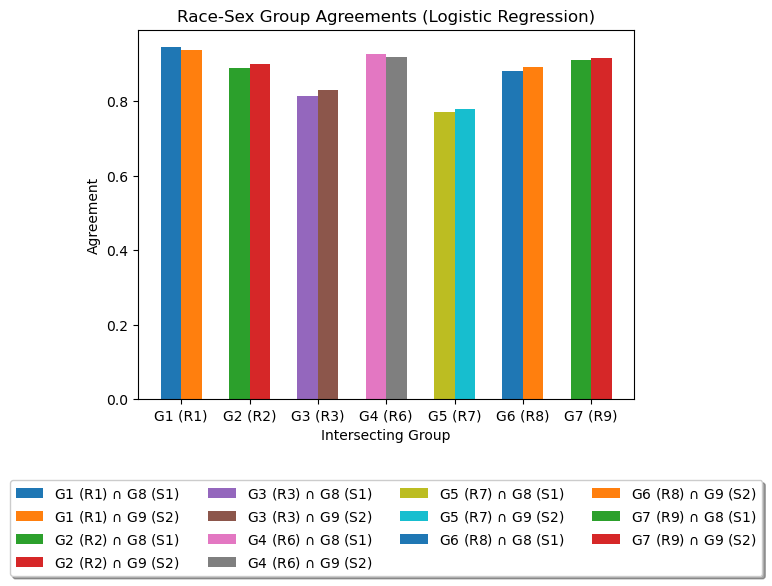

In [14]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 14
bar_groups = 7
index = np.arange(bar_groups)
bar_width = 0.3

for i in range(num_bars):
    if i % 2 == 0:
        ax.bar(int(i/2) - bar_width/2, lr_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))
    elif i % 2 == 1:
        ax.bar(int(i/2) + bar_width/2, lr_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Race-Sex Group Agreements (Logistic Regression)')
ax.set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)

plt.show()

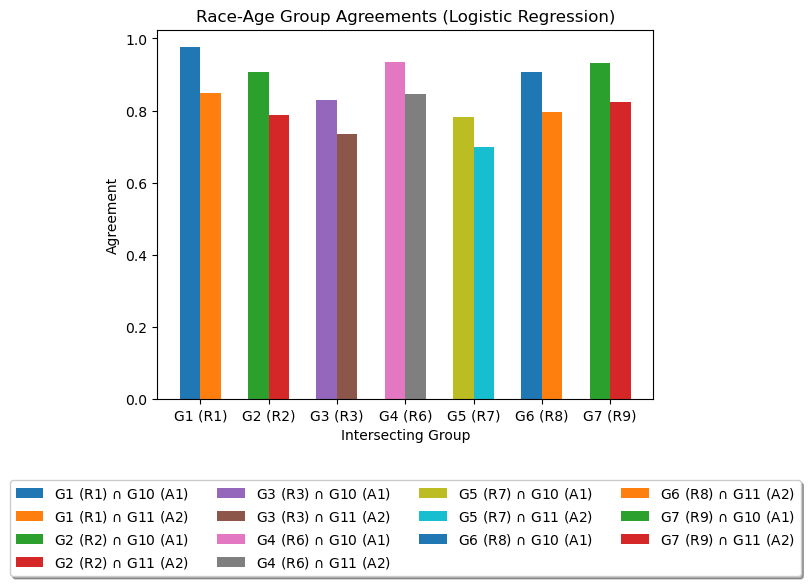

In [15]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 14
bar_groups = 7
index = np.arange(bar_groups)
bar_width = 0.3

for i in range(num_bars):
    if i % 2 == 0:
        ax.bar(int(i/2) - bar_width/2, lr_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))
    elif i % 2 == 1:
        ax.bar(int(i/2) + bar_width/2, lr_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Race-Age Group Agreements (Logistic Regression)')
ax.set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)

plt.show()

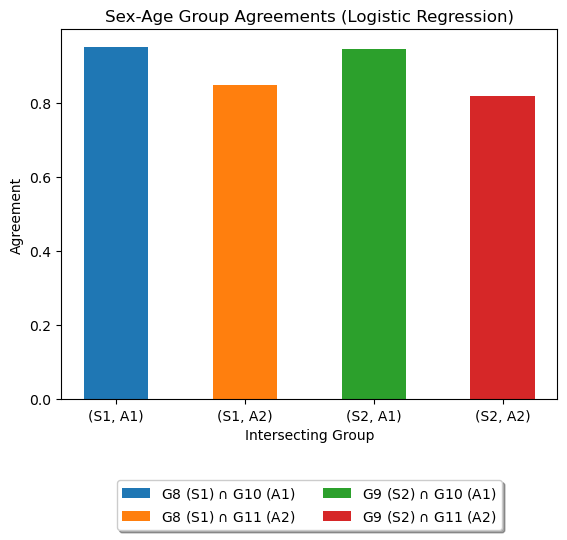

In [16]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 4
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.5

rect1 = ax.bar(0, lr_sex_age_agreements[0], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[0][0], group_names[sex_age_pairs[0][0]],
                                                            sex_age_pairs[0][1], group_names[sex_age_pairs[0][1]]))
rect2 = ax.bar(1, lr_sex_age_agreements[1], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[1][0], group_names[sex_age_pairs[1][0]],
                                                            sex_age_pairs[1][1], group_names[sex_age_pairs[1][1]]))
rect3 = ax.bar(2, lr_sex_age_agreements[2], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[2][0], group_names[sex_age_pairs[2][0]],
                                                            sex_age_pairs[2][1], group_names[sex_age_pairs[2][1]]))
rect4 = ax.bar(3, lr_sex_age_agreements[3], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[3][0], group_names[sex_age_pairs[3][0]],
                                                            sex_age_pairs[3][1], group_names[sex_age_pairs[3][1]]))


ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Sex-Age Group Agreements (Logistic Regression)')
ax.set_xticks(index, ('(S1, A1)', '(S1, A2)', '(S2, A1)', '(S2, A2)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=2)

plt.show()

# Decision Trees

In [17]:
from sklearn.tree import DecisionTreeClassifier

In [19]:
LOAD_DATA = False
best_params_path = os.path.join(SAVE_DATA_PATH, 'dectree_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'dectree_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'dectree_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        dectree_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    dectree_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        dectree_models[g] = DecisionTreeClassifier(**best_params[g])
        dectree_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = dectree_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(dectree_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

for g in range(num_groups):
    test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

group 0 (ALL): 0.2027709132972291 (+/-0.0029154161627747395; n=38038)
group 1 (R1): 0.21262275651879445 (+/-0.0037647364802994537; n=23624)
group 2 (R2): 0.22945002956830277 (+/-0.01446064475045787; n=1691)
group 3 (R3): 0.22072072072072071 (+/-0.03936467115094497; n=222)
group 4 (R6): 0.21279050601615296 (+/-0.0074310346369590875; n=6067)
group 5 (R7): 0.19607843137254902 (+/-0.04539322458483796; n=153)
group 6 (R8): 0.145610278372591 (+/-0.007299289373315398; n=4670)
group 7 (R9): 0.2206172028890348 (+/-0.01502657976323175; n=1523)
group 8 (S1): 0.20921371666089367 (+/-0.004046385232847114; n=20209)
group 9 (S2): 0.1916540467777217 (+/-0.004168781534711169; n=17829)
group 10 (A1): 0.1963039472949584 (+/-0.002967908564050363; n=35822)
group 11 (A2): 0.30415162454873645 (+/-0.013820778248771507; n=2216)
group 0 (ALL): 0.2027709132972291 (+/-0.0029154161627747395; n=38038)
group 1 (R1): 0.21262275651879445 (+/-0.0037647364802994537; n=23624)
group 2 (R2): 0.22945002956830277 (+/-0.01446

In [20]:
# Get "agreement" for each pair of intersecting groups
# Race-Sex Pairs
dt_race_sex_agreements = []
for g1, g2 in race_sex_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    dt_race_sex_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

# Race-Age Pairs
print()
dt_race_age_agreements = []
for g1, g2 in race_age_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    dt_race_age_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

# Sex-Age Pairs
print()
dt_sex_age_agreements = []
for g1, g2 in sex_age_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    dt_sex_age_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

(R1, S1) agreement:	0.8722593196277407
(R1, S2) agreement:	0.8697092381302908
(R2, S1) agreement:	0.8283295651716704
(R2, S2) agreement:	0.895026026604974
(R3, S1) agreement:	0.8091382301908617
(R3, S2) agreement:	0.8419738156580262
(R6, S1) agreement:	0.8559861191440139
(R6, S2) agreement:	0.9012303485987696
(R7, S1) agreement:	0.7993059572006941
(R7, S2) agreement:	0.805852042694148
(R8, S1) agreement:	0.8322992796677007
(R8, S2) agreement:	0.8857458331142541
(R9, S1) agreement:	0.8329565171670434
(R9, S2) agreement:	0.8541721436458278

(R1, A1) agreement:	0.9115095430884904
(R1, A2) agreement:	0.7876071297123929
(R2, A1) agreement:	0.8740470056259529
(R2, A2) agreement:	0.7264314632735686
(R3, A1) agreement:	0.8512277196487723
(R3, A2) agreement:	0.7236447762763553
(R6, A1) agreement:	0.8872969136127031
(R6, A2) agreement:	0.7520374362479626
(R7, A1) agreement:	0.8123192596876807
(R7, A2) agreement:	0.7014038592985962
(R8, A1) agreement:	0.8734423471265577
(R8, A2) agreement:	0.7327

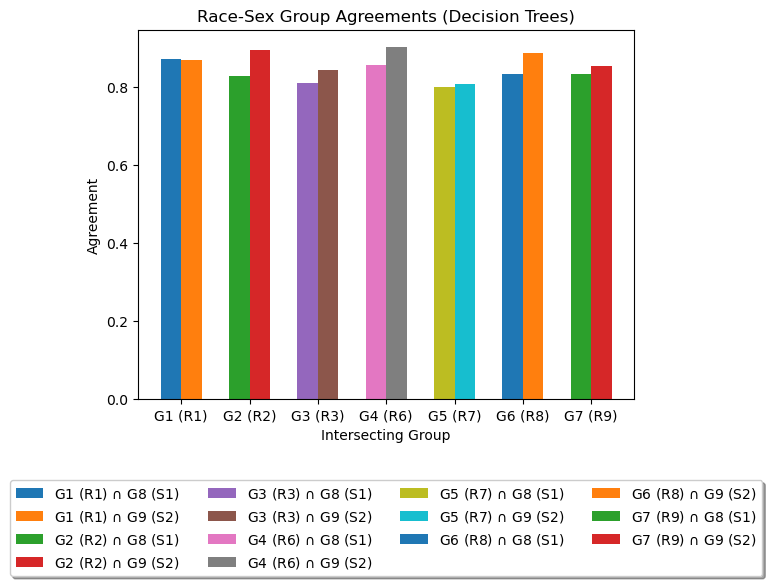

In [21]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 14
bar_groups = 7
index = np.arange(bar_groups)
bar_width = 0.3

for i in range(num_bars):
    if i % 2 == 0:
        ax.bar(int(i/2) - bar_width/2, dt_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))
    elif i % 2 == 1:
        ax.bar(int(i/2) + bar_width/2, dt_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Race-Sex Group Agreements (Decision Trees)')
ax.set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)

plt.show()

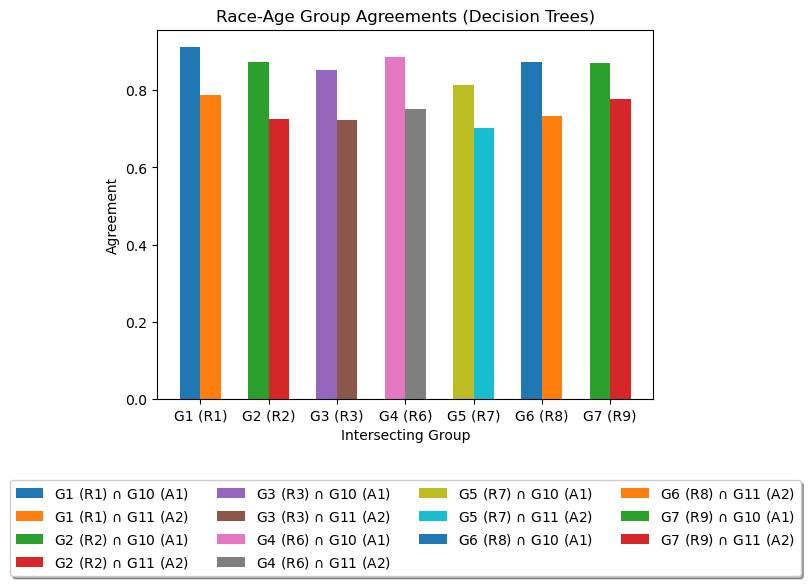

In [22]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 14
bar_groups = 7
index = np.arange(bar_groups)
bar_width = 0.3

for i in range(num_bars):
    if i % 2 == 0:
        ax.bar(int(i/2) - bar_width/2, dt_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))
    elif i % 2 == 1:
        ax.bar(int(i/2) + bar_width/2, dt_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Race-Age Group Agreements (Decision Trees)')
ax.set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)

plt.show()

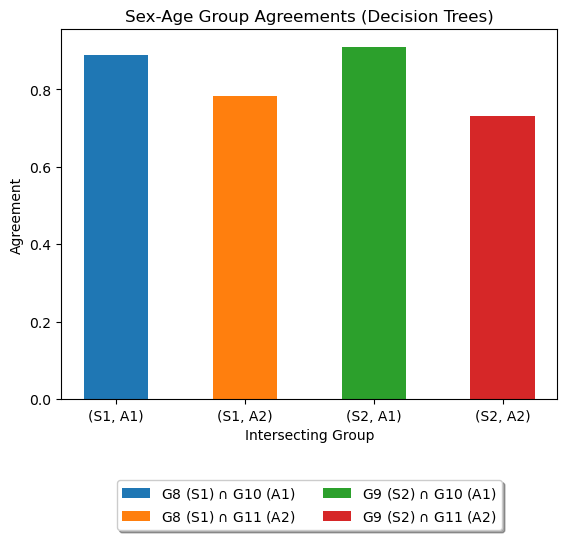

In [23]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 4
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.5

rect1 = ax.bar(0, dt_sex_age_agreements[0], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[0][0], group_names[sex_age_pairs[0][0]],
                                                            sex_age_pairs[0][1], group_names[sex_age_pairs[0][1]]))
rect2 = ax.bar(1, dt_sex_age_agreements[1], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[1][0], group_names[sex_age_pairs[1][0]],
                                                            sex_age_pairs[1][1], group_names[sex_age_pairs[1][1]]))
rect3 = ax.bar(2, dt_sex_age_agreements[2], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[2][0], group_names[sex_age_pairs[2][0]],
                                                            sex_age_pairs[2][1], group_names[sex_age_pairs[2][1]]))
rect4 = ax.bar(3, dt_sex_age_agreements[3], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[3][0], group_names[sex_age_pairs[3][0]],
                                                            sex_age_pairs[3][1], group_names[sex_age_pairs[3][1]]))


ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Sex-Age Group Agreements (Decision Trees)')
ax.set_xticks(index, ('(S1, A1)', '(S1, A2)', '(S2, A1)', '(S2, A2)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=2)

plt.show()

# Gradient-Boosted Trees

In [24]:
from sklearn.ensemble import GradientBoostingClassifier

In [25]:
LOAD_DATA = False
best_params_path = os.path.join(SAVE_DATA_PATH, 'gbm_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'gbm_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'gbm_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        gbm_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    gbm_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        gbm_models[g] = GradientBoostingClassifier(**best_params[g])
        gbm_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = gbm_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(gbm_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

for g in range(num_groups):
    test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

group 0 (ALL): 0.1767443083232557 (+/-0.002765962261427566; n=38038)
group 1 (R1): 0.18608195055875382 (+/-0.0035808056120478758; n=23624)
group 2 (R2): 0.1981076286221171 (+/-0.013707297374228995; n=1691)
group 3 (R3): 0.22972972972972974 (+/-0.03992718383609589; n=222)
group 4 (R6): 0.19037415526619417 (+/-0.007128106447293117; n=6067)
group 5 (R7): 0.19607843137254902 (+/-0.04539322458483796; n=153)
group 6 (R8): 0.12740899357601712 (+/-0.006900204569228413; n=4670)
group 7 (R9): 0.1799080761654629 (+/-0.013919436157737029; n=1523)
group 8 (S1): 0.18194863674600426 (+/-0.003838020368572115; n=20209)
group 9 (S2): 0.171350047675136 (+/-0.003990976540933219; n=17829)
group 10 (A1): 0.17168220646530066 (+/-0.002817741974860067; n=35822)
group 11 (A2): 0.25676895306859204 (+/-0.013123911603785711; n=2216)
group 0 (ALL): 0.1767443083232557 (+/-0.002765962261427566; n=38038)
group 1 (R1): 0.18608195055875382 (+/-0.0035808056120478758; n=23624)
group 2 (R2): 0.1981076286221171 (+/-0.013707

In [26]:
# Get "agreement" for each pair of intersecting groups
# Race-Sex Pairs
gb_race_sex_agreements = []
for g1, g2 in race_sex_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    gb_race_sex_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

# Race-Age Pairs
print()
gb_race_age_agreements = []
for g1, g2 in race_age_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    gb_race_age_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

# Sex-Age Pairs
print()
gb_sex_age_agreements = []
for g1, g2 in sex_age_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    gb_sex_age_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

(R1, S1) agreement:	0.9157158630842841
(R1, S2) agreement:	0.9141647825858352
(R2, S1) agreement:	0.8694989221305011
(R2, S2) agreement:	0.8914506546085493
(R3, S1) agreement:	0.8147641831852358
(R3, S2) agreement:	0.8459172406540828
(R6, S1) agreement:	0.8882959146117041
(R6, S2) agreement:	0.9160313370839687
(R7, S1) agreement:	0.8291971186708029
(R7, S2) agreement:	0.8464167411535832
(R8, S1) agreement:	0.8489931121510069
(R8, S2) agreement:	0.8915558126084442
(R9, S1) agreement:	0.8836426731163574
(R9, S2) agreement:	0.90102003259898

(R1, A1) agreement:	0.9400336505599663
(R1, A2) agreement:	0.8624007571375992
(R2, A1) agreement:	0.8929754456070246
(R2, A2) agreement:	0.8066144381933855
(R3, A1) agreement:	0.8345075976654924
(R3, A2) agreement:	0.7594510752405489
(R6, A1) agreement:	0.917819023082181
(R6, A2) agreement:	0.8320889636679111
(R7, A1) agreement:	0.8344287291655713
(R7, A2) agreement:	0.7808244387191755
(R8, A1) agreement:	0.8892423366107577
(R8, A2) agreement:	0.78347

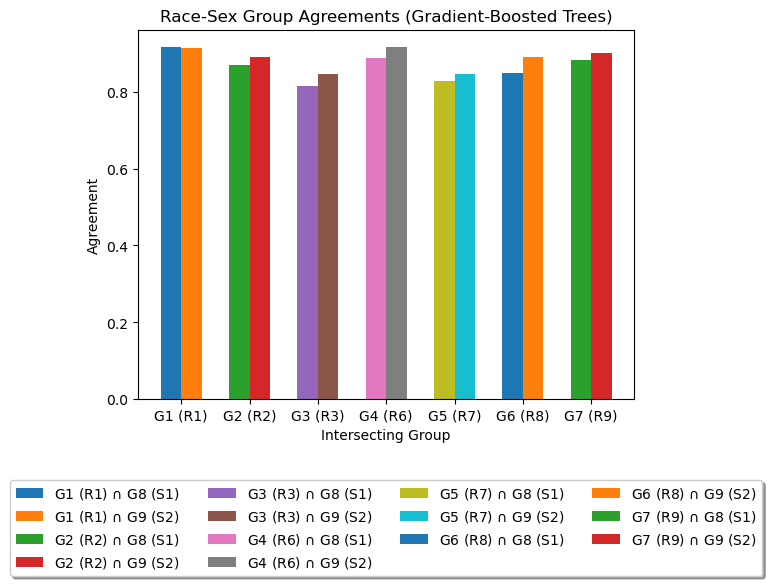

In [27]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 14
bar_groups = 7
index = np.arange(bar_groups)
bar_width = 0.3

for i in range(num_bars):
    if i % 2 == 0:
        ax.bar(int(i/2) - bar_width/2, gb_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))
    elif i % 2 == 1:
        ax.bar(int(i/2) + bar_width/2, gb_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Race-Sex Group Agreements (Gradient-Boosted Trees)')
ax.set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)

plt.show()

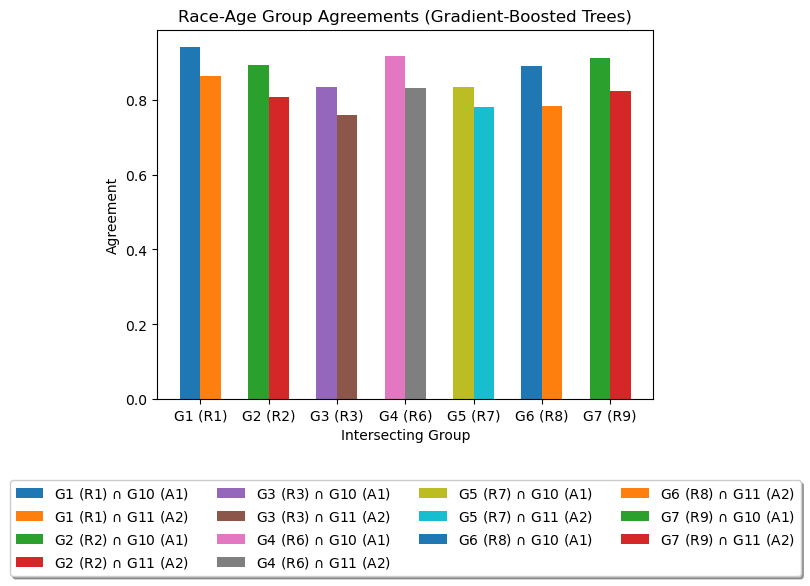

In [28]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 14
bar_groups = 7
index = np.arange(bar_groups)
bar_width = 0.3

for i in range(num_bars):
    if i % 2 == 0:
        ax.bar(int(i/2) - bar_width/2, gb_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))
    elif i % 2 == 1:
        ax.bar(int(i/2) + bar_width/2, gb_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Race-Age Group Agreements (Gradient-Boosted Trees)')
ax.set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)

plt.show()

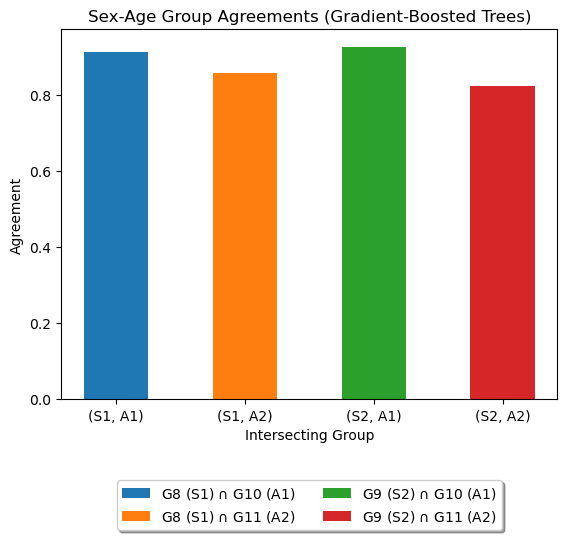

In [29]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 4
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.5

rect1 = ax.bar(0, gb_sex_age_agreements[0], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[0][0], group_names[sex_age_pairs[0][0]],
                                                            sex_age_pairs[0][1], group_names[sex_age_pairs[0][1]]))
rect2 = ax.bar(1, gb_sex_age_agreements[1], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[1][0], group_names[sex_age_pairs[1][0]],
                                                            sex_age_pairs[1][1], group_names[sex_age_pairs[1][1]]))
rect3 = ax.bar(2, gb_sex_age_agreements[2], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[2][0], group_names[sex_age_pairs[2][0]],
                                                            sex_age_pairs[2][1], group_names[sex_age_pairs[2][1]]))
rect4 = ax.bar(3, gb_sex_age_agreements[3], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[3][0], group_names[sex_age_pairs[3][0]],
                                                            sex_age_pairs[3][1], group_names[sex_age_pairs[3][1]]))


ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Sex-Age Group Agreements (Gradient-Boosted Trees)')
ax.set_xticks(index, ('(S1, A1)', '(S1, A2)', '(S2, A1)', '(S2, A2)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=2)

plt.show()

# XGBoost

In [30]:
from xgboost import XGBClassifier

In [31]:
LOAD_DATA = False
best_params_path = os.path.join(SAVE_DATA_PATH, 'xgb_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'xgb_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'xgb_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        xgb_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    xgb_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        xgb_models[g] = XGBClassifier(**best_params[g])
        xgb_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = xgb_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(xgb_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

for g in range(num_groups):
    test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

group 0 (ALL): 0.17188075082811924 (+/-0.002735685834918695; n=38038)
group 1 (R1): 0.18184896715204876 (+/-0.003549036302635998; n=23624)
group 2 (R2): 0.205204021289178 (+/-0.013888775506895223; n=1691)
group 3 (R3): 0.22072072072072071 (+/-0.03936467115094497; n=222)
group 4 (R6): 0.1875721114224493 (+/-0.0070876872470694435; n=6067)
group 5 (R7): 0.23529411764705882 (+/-0.04849779940398763; n=153)
group 6 (R8): 0.12419700214132762 (+/-0.006825199146067739; n=4670)
group 7 (R9): 0.1845042678923178 (+/-0.014056561617970913; n=1523)
group 8 (S1): 0.18016725221435995 (+/-0.003823341971541533; n=20209)
group 9 (S2): 0.16697515284087722 (+/-0.0039500846985985934; n=17829)
group 10 (A1): 0.16741108815811512 (+/-0.0027896357762142547; n=35822)
group 11 (A2): 0.25586642599277976 (+/-0.013108778373114492; n=2216)
group 0 (ALL): 0.17188075082811924 (+/-0.002735685834918695; n=38038)
group 1 (R1): 0.18184896715204876 (+/-0.003549036302635998; n=23624)
group 2 (R2): 0.205204021289178 (+/-0.0138

In [32]:
# Get "agreement" for each pair of intersecting groups
# Race-Sex Pairs
xgb_race_sex_agreements = []
for g1, g2 in race_sex_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    xgb_race_sex_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

# Race-Age Pairs
print()
xgb_race_age_agreements = []
for g1, g2 in race_age_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    xgb_race_age_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

# Sex-Age Pairs
print()
xgb_sex_age_agreements = []
for g1, g2 in sex_age_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    xgb_sex_age_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

(R1, S1) agreement:	0.9195804195804196
(R1, S2) agreement:	0.9162942320837058
(R2, S1) agreement:	0.8786476681213523
(R2, S2) agreement:	0.8938692886061307
(R3, S1) agreement:	0.843262001156738
(R3, S2) agreement:	0.8687365266312634
(R6, S1) agreement:	0.9005205320994795
(R6, S2) agreement:	0.9164256795835743
(R7, S1) agreement:	0.8355854671644145
(R7, S2) agreement:	0.8539092486460907
(R8, S1) agreement:	0.8548819601451181
(R8, S2) agreement:	0.8752563226247437
(R9, S1) agreement:	0.8922656291077343
(R9, S2) agreement:	0.9050686155949313

(R1, A1) agreement:	0.9364582785635417
(R1, A2) agreement:	0.8603238866396761
(R2, A1) agreement:	0.8884273621115726
(R2, A2) agreement:	0.8253851411746148
(R3, A1) agreement:	0.8565119091434881
(R3, A2) agreement:	0.7934696882065303
(R6, A1) agreement:	0.9126662810873337
(R6, A2) agreement:	0.8457857931542142
(R7, A1) agreement:	0.8411062621588937
(R7, A2) agreement:	0.7932067932067932
(R8, A1) agreement:	0.8760712971239287
(R8, A2) agreement:	0.804

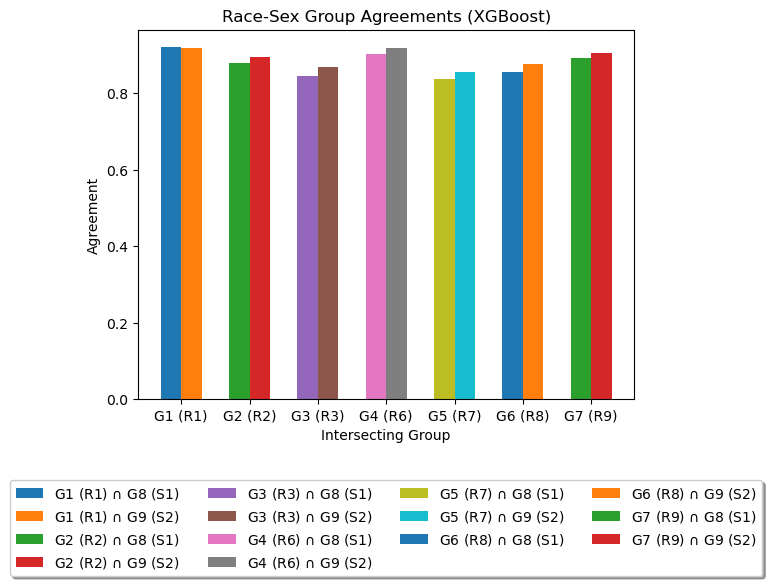

In [33]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 14
bar_groups = 7
index = np.arange(bar_groups)
bar_width = 0.3

for i in range(num_bars):
    if i % 2 == 0:
        ax.bar(int(i/2) - bar_width/2, xgb_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))
    elif i % 2 == 1:
        ax.bar(int(i/2) + bar_width/2, xgb_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Race-Sex Group Agreements (XGBoost)')
ax.set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)

plt.show()

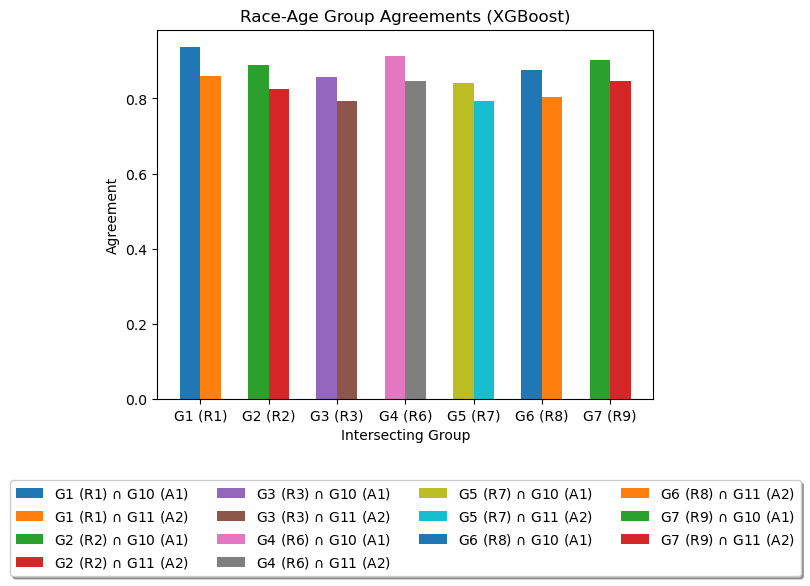

In [34]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 14
bar_groups = 7
index = np.arange(bar_groups)
bar_width = 0.3

for i in range(num_bars):
    if i % 2 == 0:
        ax.bar(int(i/2) - bar_width/2, xgb_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))
    elif i % 2 == 1:
        ax.bar(int(i/2) + bar_width/2, xgb_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Race-Age Group Agreements (XGBoost)')
ax.set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)

plt.show()

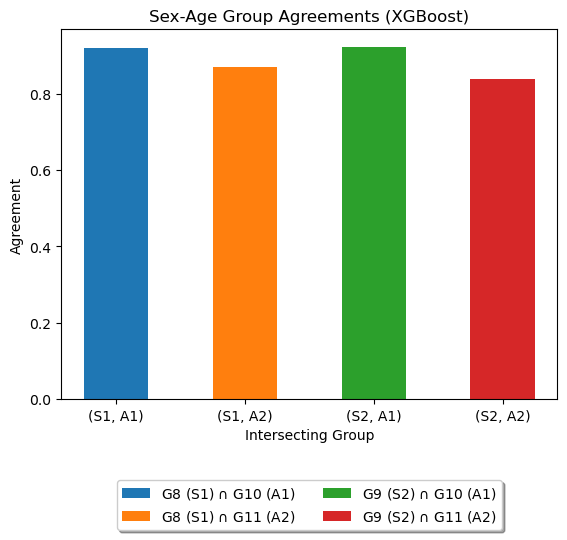

In [35]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 4
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.5

rect1 = ax.bar(0, xgb_sex_age_agreements[0], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[0][0], group_names[sex_age_pairs[0][0]],
                                                            sex_age_pairs[0][1], group_names[sex_age_pairs[0][1]]))
rect2 = ax.bar(1, xgb_sex_age_agreements[1], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[1][0], group_names[sex_age_pairs[1][0]],
                                                            sex_age_pairs[1][1], group_names[sex_age_pairs[1][1]]))
rect3 = ax.bar(2, xgb_sex_age_agreements[2], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[2][0], group_names[sex_age_pairs[2][0]],
                                                            sex_age_pairs[2][1], group_names[sex_age_pairs[2][1]]))
rect4 = ax.bar(3, xgb_sex_age_agreements[3], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[3][0], group_names[sex_age_pairs[3][0]],
                                                            sex_age_pairs[3][1], group_names[sex_age_pairs[3][1]]))


ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Sex-Age Group Agreements (XGBoost)')
ax.set_xticks(index, ('(S1, A1)', '(S1, A2)', '(S2, A1)', '(S2, A2)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=2)

plt.show()

# AdaBoost

In [36]:
from sklearn.ensemble import AdaBoostClassifier

In [37]:
LOAD_DATA = False
best_params_path = os.path.join(SAVE_DATA_PATH, 'ada_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'ada_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'ada_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        ada_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    ada_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        ada_models[g] = AdaBoostClassifier(**best_params[g])
        ada_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = ada_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(ada_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

for g in range(num_groups):
    test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

group 0 (ALL): 0.19483148430516853 (+/-0.002871964865338586; n=38038)
group 1 (R1): 0.20441076870978667 (+/-0.0037105186142683748; n=23624)
group 2 (R2): 0.2057953873447664 (+/-0.01390359839626906; n=1691)
group 3 (R3): 0.21171171171171171 (+/-0.038775150261476474; n=222)
group 4 (R6): 0.20339541783418494 (+/-0.007308360855938034; n=6067)
group 5 (R7): 0.1895424836601307 (+/-0.04481131546933817; n=153)
group 6 (R8): 0.12933618843683084 (+/-0.006944513610921615; n=4670)
group 7 (R9): 0.1871306631648063 (+/-0.014133440508306762; n=1523)
group 8 (S1): 0.1962491959028156 (+/-0.003951001904995069; n=20209)
group 9 (S2): 0.18481126254977845 (+/-0.004110974735313803; n=17829)
group 10 (A1): 0.18968790128971022 (+/-0.0029294498020649064; n=35822)
group 11 (A2): 0.2694043321299639 (+/-0.013328183202242452; n=2216)
group 0 (ALL): 0.19483148430516853 (+/-0.002871964865338586; n=38038)
group 1 (R1): 0.20441076870978667 (+/-0.0037105186142683748; n=23624)
group 2 (R2): 0.2057953873447664 (+/-0.0139

In [38]:
# Get "agreement" for each pair of intersecting groups
# Race-Sex Pairs
ada_race_sex_agreements = []
for g1, g2 in race_sex_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    ada_race_sex_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

# Race-Age Pairs
print()
ada_race_age_agreements = []
for g1, g2 in race_age_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    ada_race_age_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

# Sex-Age Pairs
print()
ada_sex_age_agreements = []
for g1, g2 in sex_age_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    ada_sex_age_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

(R1, S1) agreement:	0.9021504810978496
(R1, S2) agreement:	0.9004679530995321
(R2, S1) agreement:	0.858247016141753
(R2, S2) agreement:	0.8937378411062622
(R3, S1) agreement:	0.7397602397602397
(R3, S2) agreement:	0.8430253956569747
(R6, S1) agreement:	0.8798306956201694
(R6, S2) agreement:	0.909642988590357
(R7, S1) agreement:	0.7834270992165729
(R7, S2) agreement:	0.869236027130764
(R8, S1) agreement:	0.8345338871654661
(R8, S2) agreement:	0.8826962511173038
(R9, S1) agreement:	0.8864030706135969
(R9, S2) agreement:	0.9197907355802093

(R1, A1) agreement:	0.9397181765602818
(R1, A2) agreement:	0.8526473526473527
(R2, A1) agreement:	0.8986013986013986
(R2, A2) agreement:	0.800857037699143
(R3, A1) agreement:	0.8010936431989063
(R3, A2) agreement:	0.6918344813081655
(R6, A1) agreement:	0.9129291760870708
(R6, A2) agreement:	0.8309585151690415
(R7, A1) agreement:	0.836084967663915
(R7, A2) agreement:	0.7361848677638151
(R8, A1) agreement:	0.8818286976181713
(R8, A2) agreement:	0.7976497

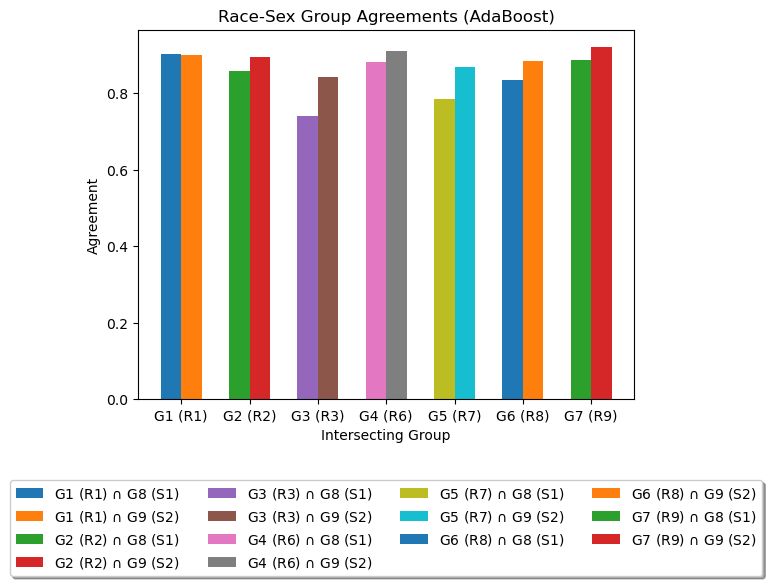

In [39]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 14
bar_groups = 7
index = np.arange(bar_groups)
bar_width = 0.3

for i in range(num_bars):
    if i % 2 == 0:
        ax.bar(int(i/2) - bar_width/2, ada_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))
    elif i % 2 == 1:
        ax.bar(int(i/2) + bar_width/2, ada_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Race-Sex Group Agreements (AdaBoost)')
ax.set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)

plt.show()

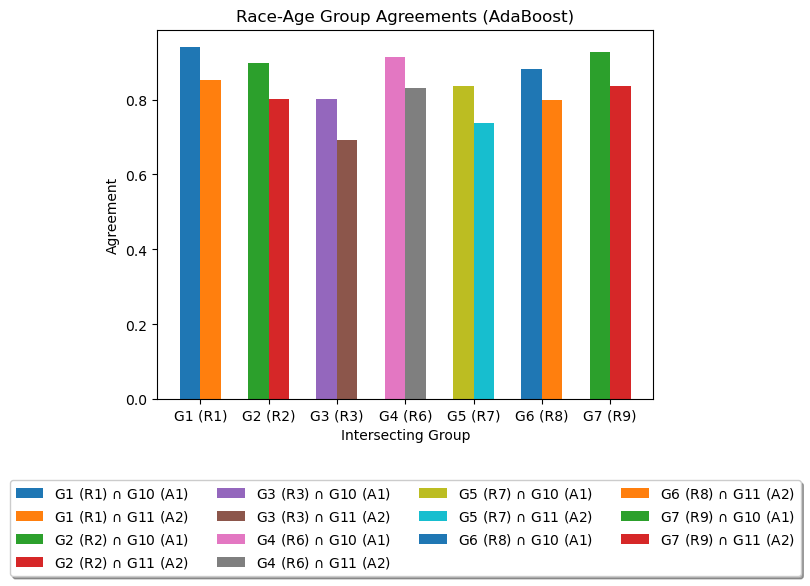

In [40]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 14
bar_groups = 7
index = np.arange(bar_groups)
bar_width = 0.3

for i in range(num_bars):
    if i % 2 == 0:
        ax.bar(int(i/2) - bar_width/2, ada_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))
    elif i % 2 == 1:
        ax.bar(int(i/2) + bar_width/2, ada_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Race-Age Group Agreements (AdaBoost)')
ax.set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)

plt.show()

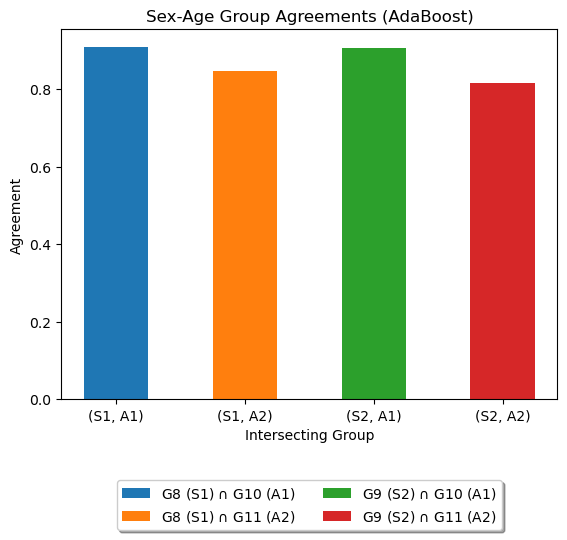

In [41]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 4
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.5

rect1 = ax.bar(0, ada_sex_age_agreements[0], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[0][0], group_names[sex_age_pairs[0][0]],
                                                            sex_age_pairs[0][1], group_names[sex_age_pairs[0][1]]))
rect2 = ax.bar(1, ada_sex_age_agreements[1], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[1][0], group_names[sex_age_pairs[1][0]],
                                                            sex_age_pairs[1][1], group_names[sex_age_pairs[1][1]]))
rect3 = ax.bar(2, ada_sex_age_agreements[2], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[2][0], group_names[sex_age_pairs[2][0]],
                                                            sex_age_pairs[2][1], group_names[sex_age_pairs[2][1]]))
rect4 = ax.bar(3, ada_sex_age_agreements[3], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[3][0], group_names[sex_age_pairs[3][0]],
                                                            sex_age_pairs[3][1], group_names[sex_age_pairs[3][1]]))


ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Sex-Age Group Agreements (AdaBoost)')
ax.set_xticks(index, ('(S1, A1)', '(S1, A2)', '(S2, A1)', '(S2, A2)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=2)

plt.show()